In [1]:
import time

def loading_time_calculator(dataloader):
    t1 = time.time()
    for data in dataloader:
        pass
    t2 = time.time()

    return t2 - t1

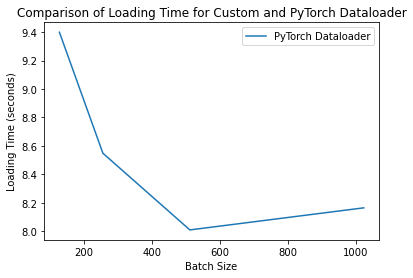

In [6]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

class pytorchMNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.mnist_data = MNIST(root=root, train=train, download=True, transform=transform)

    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, index):
        return self.mnist_data[index]

# Define transformations (you can add more augmentations if needed)
transform_torch = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Set the root directory for downloading MNIST data
download_dir = './data'

# Create instances of CustomMNISTDataset for training and testing
train_dataset_torch = pytorchMNISTDataset(root=download_dir, train=True, transform=transform_torch)
test_dataset_torch = pytorchMNISTDataset(root=download_dir, train=False, transform=transform_torch)

# Create DataLoader for training and testing
batch_sizes = [128, 256, 512, 1024]

torch_time = []
for i in batch_sizes:
    torch_dataloader = DataLoader(dataset=train_dataset_torch, batch_size=i, shuffle=True)
    duration = loading_time_calculator(torch_dataloader)
    torch_time.append(duration)

# train_loader_torch = DataLoader(dataset=train_dataset_torch, batch_size=batch_size, shuffle=True)
# test_loader_torch = DataLoader(dataset=test_dataset_torch, batch_size=batch_size, shuffle=False)


# plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

# for batch in train_loader_torch:
#     data = batch['image']
#     labels = batch['label']

#     # Your custom processing here (e.g., model training)
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)
#     break  # Stop after the first batch for this example


In [37]:
import os
import struct
import gzip
import numpy as np
from PIL import Image

class CustomMNISTDataset:
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.data = self.load_data()

    def load_data(self):
        if self.train:
            images_path = os.path.join(self.root, 'train-images-idx3-ubyte.gz')
            labels_path = os.path.join(self.root, 'train-labels-idx1-ubyte.gz')
        else:
            images_path = os.path.join(self.root, 't10k-images-idx3-ubyte.gz')
            labels_path = os.path.join(self.root, 't10k-labels-idx1-ubyte.gz')

        with gzip.open(images_path, 'rb') as img_file, gzip.open(labels_path, 'rb') as lbl_file:
            _, num_images, rows, cols = struct.unpack('>IIII', img_file.read(16))
            images = np.frombuffer(img_file.read(), dtype=np.uint8).reshape(num_images, rows, cols)
            labels = np.frombuffer(lbl_file.read(), dtype=np.uint8)

        return [{'image': img, 'label': int(lbl)} for img, lbl in zip(images, labels)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        entry = self.data[index]

        if self.transform:
            entry['image'] = self.transform(entry['image'])

        return entry

    def transform(self, image):
        # Add any image transformation logic here if needed
        # For simplicity, let's just convert the numpy array to a PIL Image
        return transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
transform_custom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # You can add your own transformations here if needed
custom_dataset = CustomMNISTDataset(root='data/MNIST/raw/', train=True, transform=transform_custom)
print(len(custom_dataset))
sample = custom_dataset[0]
print(sample['image'].size, sample['label'])

60000
<built-in method size of Tensor object at 0x0000021D0E7CC450> 0


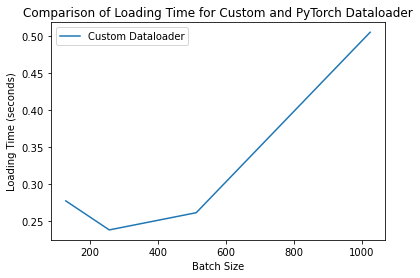

In [33]:


custom_time = []
for i in batch_sizes:
    custom_dataloader = DataLoader(custom_dataset, batch_size=i, shuffle=True)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
# plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

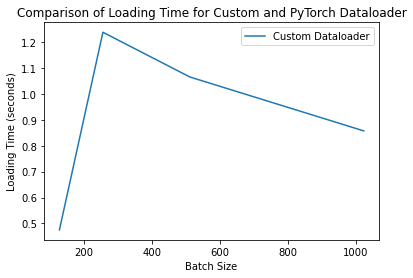

Data shape: (784,)
Label: 5
Data shape: (784,)
Label: 0
Data shape: (784,)
Label: 4
Data shape: (784,)
Label: 1
Data shape: (784,)
Label: 9


In [7]:
import os
import struct
import numpy as np

class scratchMNISTDataset:
    def __init__(self, root, train=True, transform=None):
        self.transform = transform
        self.images, self.labels = self.load_data(root, train)

    def load_data(self, root, train):
        if train:
            images_file = os.path.join(root, 'train-images-idx3-ubyte')
            labels_file = os.path.join(root, 'train-labels-idx1-ubyte')
        else:
            images_file = os.path.join(root, 't10k-images-idx3-ubyte')
            labels_file = os.path.join(root, 't10k-labels-idx1-ubyte')

        with open(images_file, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)

        with open(labels_file, 'rb') as f:
            magic, num_labels = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8)

        return [images, labels]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        label = int(self.labels[index])

        if self.transform:
            img = self.transform(img)

        return {'image': img, 'label': label}

# Example usage:
# Assuming you have downloaded the MNIST dataset files and set the root directory appropriately

# Define a simple transform function (you can customize it further)
def transform_scratch(image):
    return image.reshape(-1) / 255.0  # Flatten and normalize

root_dir = 'data/MNIST/raw/'
train_dataset_scratch = scratchMNISTDataset(root=root_dir, train=True, transform=transform_scratch)
test_dataset_sractch = scratchMNISTDataset(root=root_dir, train=False, transform=transform_scratch)


custom_time = []
for i in batch_sizes:
    custom_dataloader = DataLoader(train_dataset_scratch, batch_size=i, shuffle=True)
    duration = loading_time_calculator(custom_dataloader)
    custom_time.append(duration)

plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
# plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

# Example usage:
for idx in range(5):  # Print the first 5 samples
    sample = train_dataset_scratch[idx]
    data = sample['image']
    label = sample['label']

    # Your custom processing here (e.g., model training)
    print("Data shape:", data.shape)
    print("Label:", label)


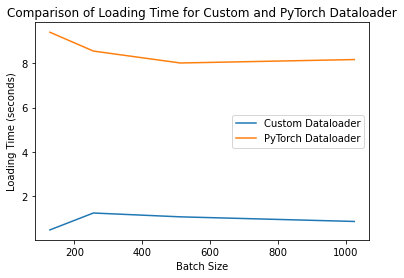

In [8]:
plt.plot(batch_sizes, custom_time, label='Custom Dataloader')
plt.plot(batch_sizes, torch_time, label='PyTorch Dataloader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.title('Comparison of Loading Time for Custom and PyTorch Dataloader')
plt.legend()
plt.show()

Since custom is faster we will use that

In [34]:
def train(model, train_loader, criterion, optimizer, epochs=60):
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            print(inputs[0])
            optimizer.zero_grad()
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the input images
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()


        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {average_train_loss:.4f}')

    return train_losses

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size) # Output layer
        
        # Define activation function (e.g., ReLU)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply activation function to each hidden layer
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        
        # Output layer (no activation for regression tasks, use softmax for classification)
        x = self.fc5(x)
        
        return x

# Define input size and output size based on your task
input_size = 784  # For MNIST images (28x28)
output_size = 10  # For 10 classes in MNIST

# Instantiate the model

# Define the model, loss function, and optimizer
model = FeedForwardNN(input_size=input_size, hidden_size=32, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003)

# Training loop
epochs = 10
torch_dataloader_train = DataLoader(dataset=custom_dataset, batch_size=128, shuffle=True)

# print(train_dataset_torch[0])

train_losses = train(model, torch_dataloader_train,criterion, optimizer, epochs=10)



i


AttributeError: 'str' object has no attribute 'view'